test[n_hours:,0]#### This code is a playground for testing different LSTM architectures 

In [1]:
import numpy as np
from math import sqrt
from datetime import datetime, timedelta
from pandas import read_csv, to_datetime, DataFrame, concat, date_range
from pandas.tseries.offsets import DateOffset
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
tf.random.set_seed(7)
import warnings
warnings.filterwarnings('ignore')

In [2]:
def Standardize(data):
    from numpy import std
    from statistics import mean
    return data - mean(data.flatten())/std(data.flatten())
# --------------------------------------------------------------------------------------------- 
def deStandardize(inv_data, data):
    from numpy import std
    from statistics import mean
    return mean(data.flatten()) + (inv_data * std(data.flatten()))
# --------------------------------------------------------------------------------------------- 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):        
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1       
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break        
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)        
	return np.array(X), np.array(y)

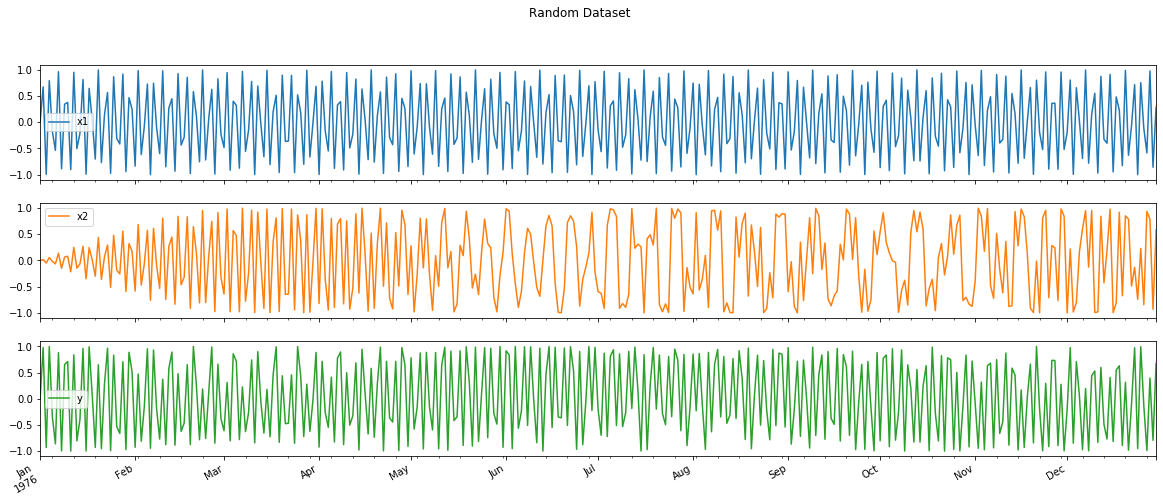

In [3]:
# creat dummy data 
start_datetime = datetime(1976, 1, 1, 0, 0, 0)
end_datetime = datetime(2019, 7, 31, 23, 0, 0)
x = date_range(start_datetime, end_datetime)

base = np.linspace(0, 382032, len(x))
y1 = np.sin(base*0.1)
y2 = np.sin(base*y1*0.001)
y3 = np.sin(y1*y2+2*y1)

df_raw = DataFrame({'x1':y1, 'x2':y2, 'y': y3}, index=x)
df_raw[:365].plot(figsize=(20,8), subplots=True, title='Random Dataset')
plt.show()

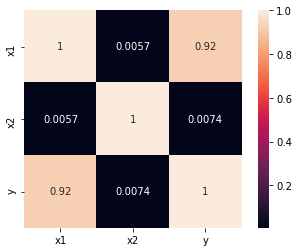

In [4]:
plt.figure()
ax = sns.heatmap(df_raw.corr(), 
                 xticklabels=df_raw.columns.values, 
                 yticklabels=df_raw.columns.values, 
                 annot=True, square=True)

heat_map = plt.gcf()
plt.show()

In [5]:
# standardize the data & convert to [rows, columns] structure 
in_seq1 = df_raw['x1'].values.reshape((len(df_raw), 1))
in_seq2 = df_raw['x2'].values.reshape((len(df_raw), 1))
out_seq = df_raw['y'].values.reshape((len(df_raw), 1))

# normalize the features between 0 and 1 
norm_in_seq1 = Standardize(in_seq1)
norm_in_seq2 = Standardize(in_seq2)
norm_out_seq = Standardize(out_seq)

# horizontally stack columns
dataset = np.hstack((norm_in_seq1, norm_in_seq2, norm_out_seq))

n_hours = int(len(dataset) * 0.8)
train, test = dataset[:n_hours], dataset[n_hours:]

# choose a number of time steps 
n_steps_in = 168
n_steps_out = 24

# covert into input/output
Xtrain, ytrain = split_sequences(train, n_steps_in, n_steps_out)
Xtest, ytest = split_sequences(test, n_steps_in, n_steps_out)

# the number of features 
n_features = Xtrain.shape[2]

def create_model():
    return tf.keras.models.Sequential(
        [
            tf.keras.layers.LSTM(n_steps_in, input_shape=(n_steps_in, n_features)), 
            tf.keras.layers.Dropout(0.2), 
            tf.keras.layers.Dense(n_steps_out)
        ])

model = create_model()
model.compile(optimizer='adam', loss='mse', metrics=['mape'])
tensorboard_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                        mode='min', patience=20, 
                                                        restore_best_weights=True, verbose=0)

In [6]:
# fit model
history = model.fit(Xtrain, ytrain, epochs=1000, validation_split=0.3, 
                    # batch_size=32, 
                    callbacks=[tensorboard_callback], verbose=0)

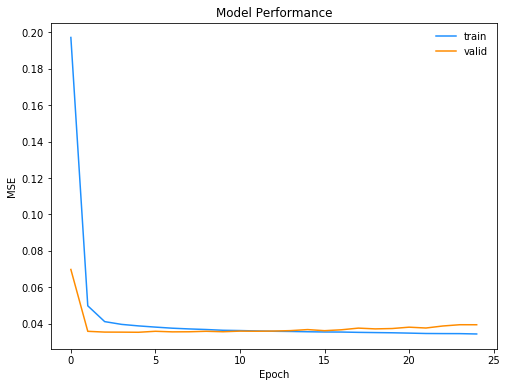

In [7]:
# plot history 
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], color='dodgerblue', label='train')
plt.plot(history.history['val_loss'], color='darkorange', label='valid')
plt.legend(loc=0, frameon=False)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('Model Performance')
plt.show()

In [8]:
Xtest.shape, ytest.shape

((2994, 168, 2), (2994, 24))

RMSE of seq# 0 = 0.23
RMSE of seq# 100 = 0.3
RMSE of seq# 200 = 0.27
RMSE of seq# 300 = 0.29
RMSE of seq# 400 = 0.3
RMSE of seq# 500 = 0.25
RMSE of seq# 600 = 0.24
RMSE of seq# 700 = 0.26


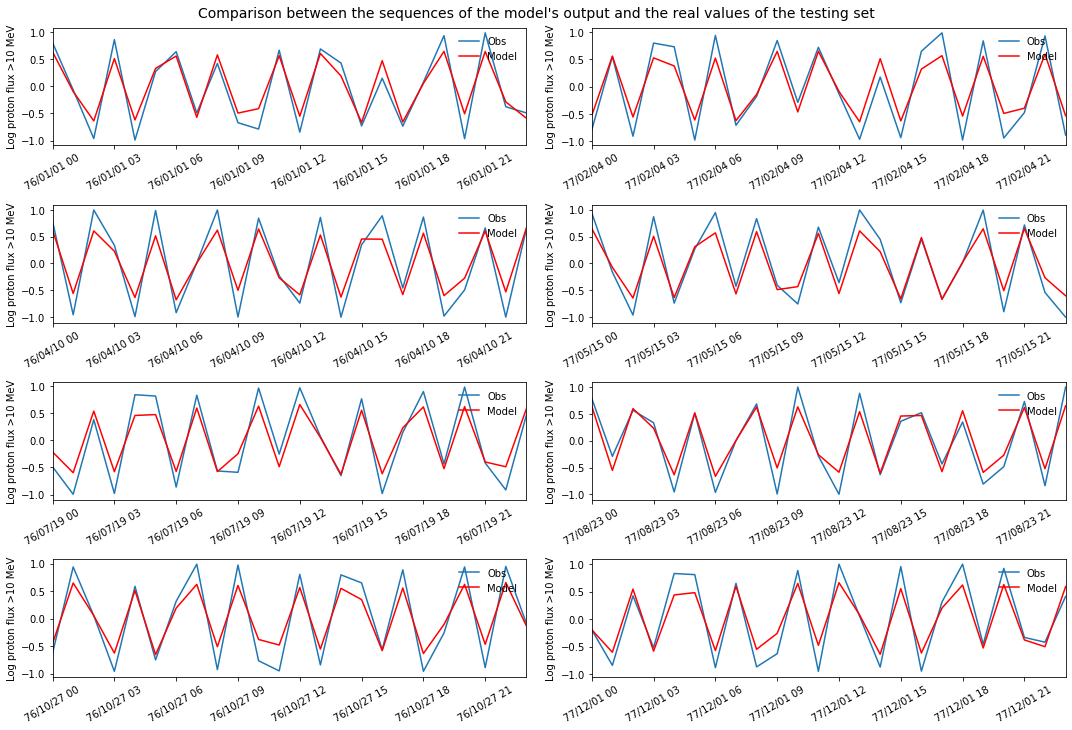

In [9]:
# demonstrate prediction for the sequences 
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,10))

seq_num = 0
for i in range(8):
    x_test, y_test = Xtest[seq_num,:,:], ytest[seq_num,:]
    x_test = x_test.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_test, verbose=0)
    yhat = yhat.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    # De-normalizing the prediction 
    yhat = deStandardize(yhat, out_seq)
    print('RMSE of seq# {} = {}' .format(seq_num, round(sqrt(mean_squared_error(y_test, yhat)),2)))
    # prepare the x-axis 
    time_idx_test = df_raw.index[seq_num:n_steps_in+seq_num]
    st_time_idx = time_idx_test[0]
    et_time_idx = [st_time_idx + timedelta(hours=x) for x in range(0, n_steps_out)]
    add_dates = date_range(st_time_idx, et_time_idx[-1], freq='1H')
    # plot a comparison 
    if i <= 3:
        axs[i,0].plot(add_dates, y_test, label='Obs')
        axs[i,0].plot(add_dates, yhat, label='Model', color='red')
        axs[i,0].set_ylabel('Log proton flux >10 MeV')
        axs[i,0].set_xlim(left=add_dates[0], right=add_dates[-1])
        axs[i,0].legend(loc='upper right', frameon=False)
        myFmt = mdates.DateFormatter('%y/%m/%d %H')
        axs[i,0].xaxis.set_major_formatter(myFmt)
        plt.setp(axs[i,0].get_xticklabels(), rotation=30)
    else:
        i -= 4
        axs[i,1].plot(add_dates, y_test, label='Obs')
        axs[i,1].plot(add_dates, yhat, label='Model', color='red')
        axs[i,1].set_ylabel('Log proton flux >10 MeV')
        axs[i,1].set_xlim(left=add_dates[0], right=add_dates[-1])
        axs[i,1].legend(loc='upper right', frameon=False)
        myFmt = mdates.DateFormatter('%y/%m/%d %H')
        axs[i,1].xaxis.set_major_formatter(myFmt)
        plt.setp(axs[i,1].get_xticklabels(), rotation=30)
    
    seq_num += 100
    x_test, y_test, yhat, time_idx_test = [], [], [], []

fig.suptitle("Comparison between the sequences of the model's output and the real values of the testing set", size=14, y=1.01)
fig.tight_layout(h_pad=1, w_pad=2)
plt.show()

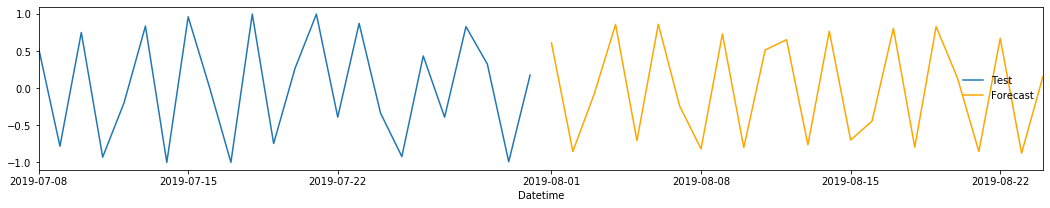

In [54]:
# demonstrate forecasting beyond the dataset -- Unknown Future 
test_forecast = DataFrame({'x1':test[:,0], 'x2':test[:,1], 'y':test[:,2]}, index=df_raw.index[n_hours:])
x_input_forecast = test_forecast[['x1', 'x2']].tail(n_steps_in).values
x_input_forecast = x_input_forecast.reshape((1, n_steps_in, n_features))
yhat_forecast = model.predict(x_input_forecast, verbose=0)
future_time_idx = date_range(to_datetime(test_forecast.tail(48).index)[0], periods=48+n_steps_out)
df_forecast = DataFrame(yhat_forecast.transpose(), index=future_time_idx[-n_steps_out:], columns=['Forecast'])

# show the last 24 timesteps + the new forecast 
fig, ax = plt.subplots(figsize=(18,3))
ax.plot(test_forecast.index[-24:], test_forecast['y'][-24:], label='Test')
ax.plot(df_forecast.index, df_forecast['Forecast'], label='Forecast', color='orange')
ax.set_xlabel('Datetime')
ax.legend(loc=0, frameon=False)
plt.xlim(left=test_forecast.index[-24:][0], right=df_forecast.index[-1])
plt.show()